In [47]:
import pandas as pd
import altair as alt
from altair import datum
alt.renderers.enable('notebook')
import numpy as np

In [298]:
data = pd.read_csv('GLB.Ts+dSST.csv')

In [299]:
average_year = data.melt(id_vars='Year', value_vars=months).groupby("Year").mean()
line_data = average_year.loc[1880:1899]

In [300]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [301]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [992]:
average_year = data.melt(id_vars='Year', value_vars=months).groupby("Year").aggregate({
    'value': {
        'low':min,
        'high':max,
        'q05': percentile(25),
        'q95': percentile(75),
        'var': np.var,
        'mean': np.mean
    }
})

/Users/sasha/programming/edu/ucu/dataviz/.env/lib/python3.7/site-packages/pandas/core/groupby/generic.py:1315: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [993]:
df = average_year.reset_index(level=0, col_level=1)
df.columns = df.columns.droplevel()

In [994]:
variance = df['var'].nlargest(10).iloc[3]

In [995]:
df = df.assign(high_var=lambda x: x['var'] >= variance)

In [996]:
df.head()

,Year,low,high,q05,q95,var,mean,high_var
0,1880,-0.29,-0.09,-0.2300,-0.1475,0.003536,-0.185833,False
1,1881,-0.21,0.04,-0.1775,-0.0100,0.009245,-0.095000,False
2,1882,-0.26,0.15,-0.2100,-0.0275,0.021390,-0.104167,False
3,1883,-0.39,-0.08,-0.2050,-0.1375,0.007408,-0.189167,False
4,1884,-0.42,-0.08,-0.3625,-0.2550,0.010045,-0.289167,False


In [997]:
config = {
    'stick_opacity': 0.5,
}

In [998]:
mean_line = alt.Chart(line_data.reset_index()).mark_rule(color='red', size=0.5).encode(y='mean(value)')

In [999]:
trend_line = alt.Chart(df.assign(mean=df['mean'].ewm(com=10).mean()))\
.mark_line(size=1, opacity=0.3, color='blue')\
.encode(x="Year", y='mean')

In [1000]:
stick = alt.Chart(df)\
.mark_rule(size=0.5, color='black', opacity=config['stick_opacity'])\
.encode(x=alt.X('Year:Q', scale=alt.Scale(zero=False)), y='low', y2='high')

In [1001]:
candles = alt.Chart(df, width=900, height=400)\
.mark_rule(size=3.5, opacity=0.8, color='darkgreen')\
.encode(x=alt.X('Year:Q', scale=alt.Scale(zero=False), axis=alt.Axis(format="d", title="")),
        y=alt.Y('q95', axis=alt.Axis(format="+S", title="")),
        y2=alt.Y('q05'))

In [1002]:
low_stick = alt.Chart(df)\
.mark_tick(color='black', thickness=5, size=1, opacity=config['stick_opacity'])\
.encode(x=alt.X('Year:Q', scale=alt.Scale(zero=False)), y='low')

In [1003]:
high_stick=alt.Chart(df)\
.mark_tick(color='black', thickness=5, size=1, opacity=config['stick_opacity'])\
.encode(x=alt.X('Year:Q', scale=alt.Scale(zero=False)), y='high')


In [1004]:
title = alt.Chart(pd.DataFrame([[1800,0.5]]))\
.mark_text(text='Annual Global Surface Temperature, Relative to Late 19th Century Average',
           align='center', fontSize=16, fontWeight="bold",dx=0, dy=-210)

In [1005]:
mean_line_text_hotter = alt.Chart(pd.DataFrame([[1800, -0.2]]))\
.mark_text(text='⬆HOTTER', align='center', fontSize=8, fontWeight="bold",dx=430, dy=90, color='darkred')
mean_line_text_colder = alt.Chart(pd.DataFrame([[1800, -0.2]]))\
.mark_text(text='⬇COLDER', align='center', fontSize=8, fontWeight="bold",dx=430, dy=107, color='darkblue')

In [1006]:
legend_stick = alt.Chart(pd.DataFrame({'Year': [1890], 'y1': [0.5], 'y2': [1.25]}))\
.mark_rule(size=0.5, opacity=config['stick_opacity'] + 0.3).encode(x='Year', y='y1', y2='y2')+\
alt.Chart(pd.DataFrame({'Year': [1890], 'y1': [0.5], 'y2': [1.25]}))\
.mark_tick(size=1, thickness=5, opacity=config['stick_opacity'] + 0.2, color='black').encode(x='Year', y='y1')+\
alt.Chart(pd.DataFrame({'Year': [1890], 'y1': [0.5], 'y2': [1.25]}))\
.mark_tick(size=1, thickness=5, opacity=config['stick_opacity'] + 0.2, color='black').encode(x='Year', y='y2')+\
alt.Chart(pd.DataFrame({'Year': [1890], 'y1': [0.7], 'y2': [1.1]}))\
.mark_rule(size=5, color='darkgreen').encode(x='Year', y='y1', y2='y2')

In [1015]:
legend_text =\
alt.Chart(pd.DataFrame({'Year': [1888], 'value': [1.225]}))\
.mark_text(text="max", size=9).encode(x='Year', y='value')+\
alt.Chart(pd.DataFrame({'Year': [1887.9], 'value': [1.098]}))\
.mark_tick(size=1, thickness=32, color='black', opacity=0.2).encode(x='Year', y='value')+\
alt.Chart(pd.DataFrame({'Year': [1883.8], 'value': [1.081]}))\
.mark_text(text="75%", size=9).encode(x='Year', y='value')+\
alt.Chart(pd.DataFrame({'Year': [1883.8], 'value': [0.691]}))\
.mark_text(text="25%", size=9).encode(x='Year', y='value')+\
alt.Chart(pd.DataFrame({'Year': [1887.9], 'value': [0.70]}))\
.mark_tick(size=1, thickness=32, color='black', opacity=0.2).encode(x='Year', y='value')+\
alt.Chart(pd.DataFrame({'Year': [1888], 'value': [0.5]}))\
.mark_text(text="min", size=9).encode(x='Year', y='value')+\
alt.Chart(pd.DataFrame({'Year': [1890], 'value': [1.32]}))\
.mark_text(text="Observations", size=13, fill='black').encode(x='Year', y='value')

In [1016]:
trend_line_legend = alt.Chart(pd.DataFrame({'Year': [1905], 'value': [1]}))\
.mark_tick(size=2, thickness=120, color='blue', opacity=0.3).encode(x='Year', y='value')+\
alt.Chart(pd.DataFrame({'Year': [1905], 'value': [1.02]}))\
.mark_text(text="Smoothed trend line", size=10).encode(x='Year', y='value')

In [1017]:
mean_line_legend = alt.Chart(pd.DataFrame({'Year': [1905], 'value': [0.8]}))\
.mark_tick(size=2, thickness=120, color='red', opacity=0.3).encode(x='Year', y='value')+\
alt.Chart(pd.DataFrame({'Year': [1905], 'value': [0.82]}))\
.mark_text(text="19th Century Average", size=10).encode(x='Year', y='value')

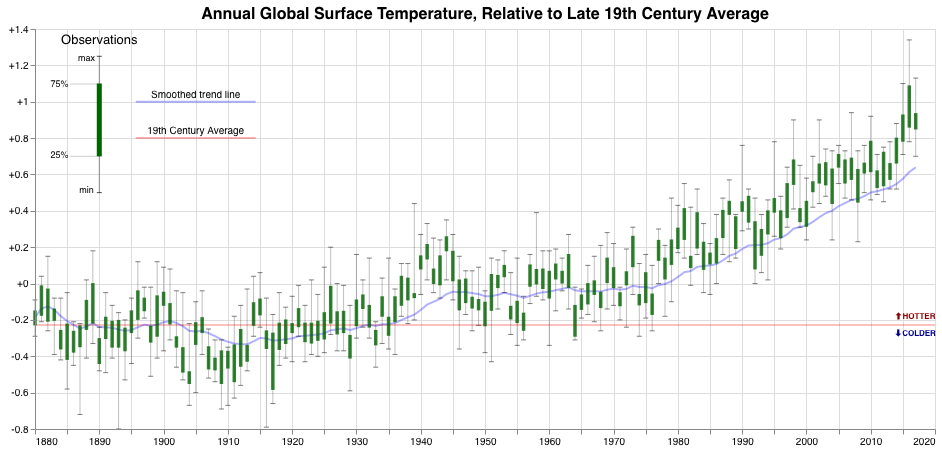

In [1018]:
chart = mean_line + trend_line +\
stick + low_stick + high_stick +\
candles + legend_text + legend_stick +\
trend_line_legend + mean_line_legend + title + mean_line_text_hotter + mean_line_text_colder
chart.display(renderer='svg')